In [51]:
# Dependencies
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, PolynomialFeatures


from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, GroupKFold



from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [3]:
# Select columns
def select_columns(dataset, columns_to_keep):
    """Filters columns of `dataset` to keep only those specified by the `columns_to_keep` paramater

    Args:
        dataset (Pandas DataFrame): Dataset to filter
        columns_to_keep ( regex expression, str): columns names to keep

    Returns:
        Pandas Dataframe: Dataset with selected column(s)
    """
    column_filter = dataset.columns.str.replace(
        'android.sensor.|mean|std|min|max|#', '', regex=True).str.fullmatch(columns_to_keep)

    return dataset.loc[:, column_filter]


# drop column(s) based on missing value percentage
def drop_col_percent_na(dataset, threshold):
    """Drop columns missing value greater than `threshold`

    Args:
        dataset (Pandas Dataframe): Dataframe from which to drop columns
        threshold (float/int): Percentage of NaN beyong which a column should be dropped (from 1 to 100)

    Returns:
        Pandas Dataframe: Dataset with dropped column(s)
    """
    to_drop = (dataset.isnull().sum()/dataset.shape[0]*100) > threshold

    return dataset.loc[:, ~to_drop]


# Split train test sets
def split_train_test(data, upper_boundary=1, lower_boundary=3, nb_users_test=3):
    """Split `data` into train and test sets based on users. Users with highest number of
    records as well as very few numbers of records are excluded from being choosen for the test set.

    Args:
        data (Pandas DataFrame): Dataset to split
        upper_boundary (int, optional): Controls k-number of users with high number of records to exclude. Defaults to 1.
        lower_boundary (int, optional): Controls k-number of users with low number of records to exclude. Defaults to 3.
        nb_users_test (int, optional): Number of users to include in the test set. Defaults to 3.

    Returns:
        Tuple(Pandas DataFrame, Pandas DataFrame): Both train and test sets
    """
    np.random.seed(0)

    # number of records per user (sorted from highest to lowest)
    user_dist = data.user.value_counts()

    # array of users from which to choose the ones going into test set
    to_choose_from = user_dist[upper_boundary: len(
        user_dist) - lower_boundary].index

    # users in test set
    test_users = np.random.choice(to_choose_from, nb_users_test, replace=False)

    # splitting into train and test sets
    train = pd.DataFrame()
    test = pd.DataFrame()
    for _, row in data.iterrows():
        if row["user"] in test_users:
            test = pd.concat([test, row], axis=1)

        else:
            train = pd.concat([train, row], axis=1)

    return train.T, test.T


# Preprocessing + model pipeline
def pipelines(models):
    """Create pipelines made up preprocessors(Imputer, StandardScaler) and models

    Args:
        models (dict): A dictionary of model's name as key and sklearn corresponding algorithm as value

    Returns:
        dict: A dictionary of model's name as key and pipeline (preprocessing + model) as value
    """

    # Preprocessors
    # imputer = IterativeImputer(random_state=0, max_iter=30)
    imputer = KNNImputer()
    # imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler()

    # Pipelines of preprocessor(s) and models
    pipes = {name: Pipeline([
        ('imputer', imputer),
        ('scaler', scaler),
        ('model', model)
    ]) for name, model in models.items()}

    return pipes


# Model performance
@ignore_warnings(category=ConvergenceWarning)
def perfomance(pipes, X_train, y_train, X_test, y_test):
    """Compute mean and std of cross validation scores, accuracy on test set
       as well as training and predicting time

    Args: pipes(dict); as defined in `pipelines` function.
          X_train, y_train; training sets
          X_test, y_test; test sets

    Returns:
        Pandas Dataframe: Dataframe of computed performance metrics sorted by accuracy on test set
    """
    results = pd.DataFrame()

    for i in tqdm(range(len(pipes))):

        name = list(pipes.keys())[i]
        model = list(pipes.values())[i]

        # training time
        t0 = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - t0

        # predicting time
        t0 = time.time()
        preds = model.predict(X_test)
        pred_time = time.time() - t0

        # cross validation
        # scores = cross_val_score(model, X_train, y_train)

        # append to results
        results = pd.concat([results, pd.DataFrame({'name': [name],
                                                    # 'mean_score': [scores.mean()],
                                                    # 'std_score':[scores.std()],
                                                    'test_accuracy': [accuracy_score(y_test, preds)],
                                                    'balanced_accuracy':[balanced_accuracy_score(y_test, preds)],
                                                    'training_time': [train_time],
                                                    'predicting_time': [pred_time]})
                             ])

    return results.sort_values(by='test_accuracy', ascending=False)


# Load Data

In [4]:
# Load data
data = pd.read_csv('data/dataset_5secondWindow.csv')

df = data.copy()


# Explore

# Preprocessing

In [5]:
# Select columns to use
keep_columns = 'accelerometer|sound|orientation|linear_acceleration|speed|gyroscope|rotation_vector|game_rotation_vector|gyroscope_uncalibrated|target|user'
df = select_columns(df, keep_columns)


In [6]:
# Drop columns with high percentage of missing values
df = drop_col_percent_na(df, 50)

# Train Test split

In [7]:
# Train split
train, test = split_train_test(df)

In [15]:
train.target.value_counts()

Walking    1140
Bus        1032
Train       928
Car         896
Still       755
Name: target, dtype: int64

In [8]:
test.target.value_counts()

Still      424
Car        284
Train      251
Bus        146
Walking     37
Name: target, dtype: int64

In [63]:
# Features target separation
X_train, y_train = train.drop(columns=['target', 'user']), train['target']

X_test, y_test = test.drop(columns=['target', 'user']), test['target']

In [67]:
# Binarize target
y_train = train['target'].apply(lambda x: 1 if x == 'Walking' else 0)
y_test = test['target'].apply(lambda x: 1 if x == 'Walking' else 0)

# Training

In [68]:
# Pipelines (preprocessing + model)
models = {'rf': RandomForestClassifier(random_state=0),
          "gb": GradientBoostingClassifier(random_state=0),
          'dt': DecisionTreeClassifier(),
          'extraT': ExtraTreesClassifier(),
        #   'xgb':XGBClassifier(),
          'svm': SVC(), 
          'mlp': MLPClassifier(random_state=0, max_iter=1000),
          'sgd': SGDClassifier(random_state=0)
          }


pipes = pipelines(models)


# Performance

results = perfomance(pipes, X_train, y_train, X_test, y_test)
print('Performance: \n', results)

100%|██████████| 7/7 [00:59<00:00,  8.54s/it]

Performance: 
      name  test_accuracy  balanced_accuracy  training_time  predicting_time
0  extraT       0.947461           0.907546       4.366999         1.008017
0      rf       0.945709           0.893580       6.652926         1.075130
0     mlp       0.935201           0.848967      17.913111         1.581082
0      gb       0.928196           0.871469       9.378581         1.017145
0     svm       0.915061           0.890803       4.290997         1.124035
0      dt       0.900175           0.804745       4.121532         0.991985
0     sgd       0.874781           0.817745       4.830139         1.435273


In [74]:
model = ExtraTreesClassifier()
# imputer = IterativeImputer()
imputer = KNNImputer()
# imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

pipe = Pipeline([
    ('imputer', imputer), 
    ('scaler', scaler), 
    ('model', model)])

0.9439579684763573

<Figure size 864x576 with 0 Axes>

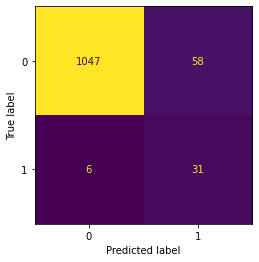

In [75]:

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
plt.figure(figsize = (12, 8))
ConfusionMatrixDisplay.from_predictions(y_test, preds, colorbar=False)
accuracy_score(y_test, preds)